# A class that implements the Moho inversion algorithm

This notebook presents a Python class that implements the proposed method. We'll use the [inverse problems framework](http://www.fatiando.org/api/inversion.html) of the library [Fatiando a Terra](http://www.fatiando.org). The class `MohoGravityInvSpherical` is defined in the [`moho.py`](moho.py) file.

## The Moho inversion method

Using the `fatiando.inversion` API. The inversion will be based on the method of Silva et al. 2014 to speedup computations. Silva et al. 2014 modify Bott's (1960) method. They show that Bott's method is a special case of the Gauss-Newton method

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k + \left[\mathbf{A}^T \mathbf{A}\right]^{-1} \mathbf{A}^T [\mathbf{d}^o - \mathbf{d}(\mathbf{p}^k)]
$$

but with the Jacobian $\mathbf{A}$ approximated by a diagonal with 

$$
A_{ii} = 2\pi G \rho
$$. 

Silva et al. also implement a step size modification algorithm similar to Marquardt's method to speed up convergence.
 
Silva et al. don't actually solve the Gauss-Newton iterations to avoid the linear systems. However, all matrices involved are (very) sparse. The `fatiando.inversion` package can handle `scipy.sparse` matrices transparently so we'll use the standard inversion classes with sparse matrices for our implementation.

The step size modification algorithm can then be substituted by the Levemberg-Marquardt algorithm because solving the sparse linear systems is trivial and very fast.

We can further expand the method to cast Bott's method as a special case of the Steepest Descent algorithm. 
The step in the Steepest Descent method is

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k - \nabla \Theta(\mathbf{p}^k) 
= \mathbf{p}^k + 2\mathbf{A}^T \left[\mathbf{d}^o - \mathbf{d}(\mathbf{p}^k)\right]
$$

Bott's method would then be the special case of $\mathbf{A}$ being a diagonal matrix with 

$$
A_{ii} = \frac{1}{2(2 \pi G \rho_i)}.
$$

Both cases are implemented in the class `Moho` below. The Jacobian will be calculated appropriately, depending on the optimization method used.

## Test the class on some simple synthetic data

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import multiprocessing
import time
from IPython.display import Image
import matplotlib.pyplot as plt
from fatiando.inversion import Smoothness2D, LCurve
from fatiando.vis import myv, mpl
from fatiando.gravmag import tesseroid
from fatiando import utils, gridder
import fatiando
from tesseroid_mesh import TesseroidRelief
from moho import MohoGravityInvSpherical

In [2]:
print(fatiando.__version__)

600e5e0716f20b6b5ffac085ccaf784c83ccb7e7


In [3]:
# Get the number of cores in the computer to run the forward modeling in parallel
ncpu = multiprocessing.cpu_count()
ncpu

4

In [4]:
shape = (30, 30)
# Make a regular grid inside an area
area = (-40, 40, 20, 60)
lon, lat, h = gridder.regular(area, shape, z=250e3)
# The model area is slightly larger because the points generated above are in the center of each cell.
dlon, dlat = gridder.spacing(area, shape)
modelarea = (area[0] - dlon/2, area[1] + dlon/2, area[2] - dlat/2, area[3] + dlat/2)
# Make a checkerboard relief undulating along the -35km height reference
f = 0.2
reference = -35e3
relief = 10e3*np.sin(f*lon)*np.cos(f*lat) + reference
# The density contrast is negative if the relief is below the reference
density = 600*np.ones_like(relief)
density[relief < reference] *= -1

In [5]:
model = TesseroidRelief(modelarea, shape, relief, reference, {'density': density})

In [6]:
def plot_result_3d(moho, fname):
    bounds = modelarea + (-20e3, -60e3)
    scale = (1, 1, 40) # Exaggerate the radial dimension
    datarange = np.abs([moho.props['density'].max(), moho.props['density'].min()]).max()
    scene = myv.figure(zdown=False)
    plot = myv.tesseroids(moho, 'density', scale=scale)
    plot.module_manager.scalar_lut_manager.show_legend = True
    plot.module_manager.scalar_lut_manager.lut_mode = 'RdYlBu'
    plot.module_manager.scalar_lut_manager.data_range = [-datarange, datarange]
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.minimum_size = np.array([1, 1])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position2 = np.array([ 0.13741855,  0.64385382])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position = np.array([ 0.03303258,  0.07342193])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.maximum_size = np.array([100000, 100000])
    plot.module_manager.scalar_lut_manager.label_text_property.color = (0, 0, 0)
    plot.module_manager.scalar_lut_manager.title_text_property.color = (0, 0, 0)
    scene.scene.camera.position = [2252864.9143914036, -5202911.2574882135, 8495162.9722945951]
    scene.scene.camera.focal_point = [3135763.9476126051, 1056258.4985192744, 829277.18542720564]
    scene.scene.camera.view_angle = 30.0
    scene.scene.camera.view_up = [0.6164057832087273, 0.57367112225287575, 0.53939350563383837]
    scene.scene.camera.clipping_range = [783483.44437851617, 16078402.004277557]
    scene.scene.camera.compute_view_plane_normal()
    scene.scene.render()
    myv.savefig(fname)
    #myv.show()
    myv.mlab.close()
    return Image(filename=fname)    

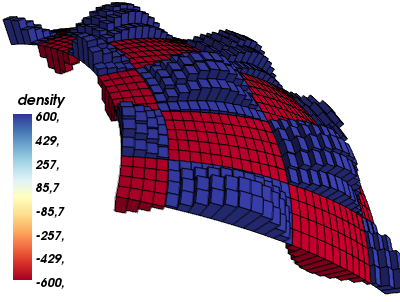

In [7]:
plot_result_3d(model, 'simple-synthetic-model.png')

For a sythetic test, I'll try to invert the sample mesh above from noise corrupted data.

In [8]:
gz = tesseroid.gz(lon, lat, h, model, njobs=ncpu)
gz = utils.contaminate(gz, 5, seed=0)

/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


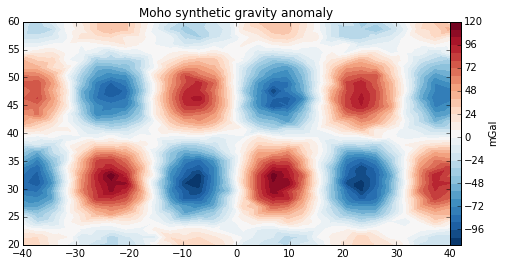

In [9]:
plt.figure(figsize=(9, 4))
plt.title('Moho synthetic gravity anomaly')
plt.tricontourf(lon, lat, gz, 30, cmap='RdBu_r')
plt.colorbar(pad=0).set_label('mGal')

First, configure the inversion:

In [10]:
# Make a mesh
mesh = model.copy(deep=True)
mesh.props['density'] = 600*np.ones(mesh.size)
# Create the solver (using all available CPU cores)
solver = MohoGravityInvSpherical(lon, lat, h, gz, mesh, njobs=ncpu)
# Configure the optimization method
initial = np.ones(solver.nparams)*(mesh.reference - 30e3)
solver.config('steepest', initial=initial, tol=0.2, linesearch=False)

In [11]:
# Run the inversion and time the computation
t0 = time.time()
solver.fit()
dt = time.time() - t0
print("Time it took: {} s".format(dt))

Time it took: 8.03834199905 s


Plot the RMS per iteration to get an idea of the convergence of the method.

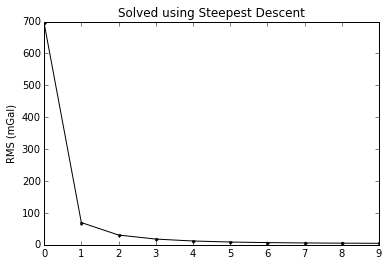

In [12]:
plt.figure()
ax1 = plt.subplot(111)
ax1.set_title('Solved using {}'.format(solver.stats_['method']))
rms = np.sqrt(solver.stats_['objective'])/np.sqrt(solver.ndata)
ax1.plot(rms, '.k-')
ax1.set_ylabel('RMS (mGal)')

Plot the data misfit and residuals

In [13]:
predicted = solver.predicted()
residuals = solver.residuals()
moho = solver.estimate_

/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/contour.py:381: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


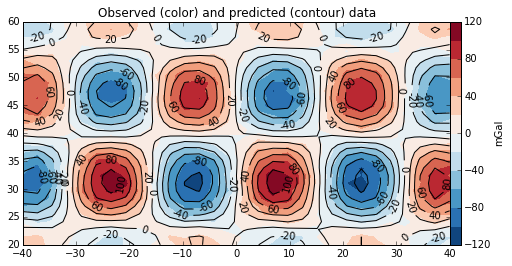

In [14]:
plt.figure(figsize=(9, 4))
levels = mpl.contourf(lon, lat, gz, shape, 12, cmap='RdBu_r')
plt.colorbar(pad=0).set_label('mGal')
mpl.contour(lon, lat, predicted, shape, levels)
plt.title('Observed (color) and predicted (contour) data')

Mean: 0.290199024569   std: 4.71115385727


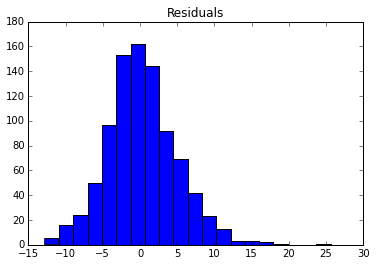

In [15]:
plt.title('Residuals')
plt.hist(residuals, bins=20)
print('Mean: {}   std: {}'.format(residuals.mean(), residuals.std()))

Map the estimated Moho depth.

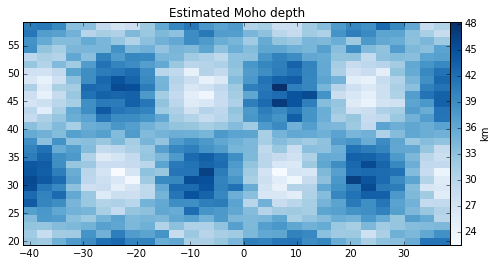

In [16]:
plt.figure(figsize=(9, 4))
plt.title("Estimated Moho depth")
mpl.pcolor(lon - dlon/2, lat - dlat/2, -0.001*moho.relief, shape, cmap='Blues')
plt.colorbar(pad=0).set_label('km')

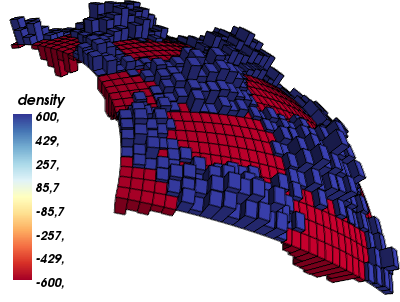

In [17]:
plot_result_3d(moho, 'simple-synthetic.png')

## Profile the inversion to see what is slow

I'll run the Python profiler (using the `%prun` IPython magic) to see where time is being spent in the inversion. I'll test the inversion by Gauss-Newton to see if solving the linear system has any impact on performance.

In [18]:
%prun -l 15 -q -T profiling.txt MohoGravityInvSpherical(lon, lat, h, gz, mesh).config('newton', initial=initial, tol=0.2).fit()
%cat profiling.txt

 
*** Profile printout saved to text file u'profiling.txt'. 
         1998036 function calls (1871831 primitive calls) in 12.504 seconds

   Ordered by: internal time
   List reduced from 1565 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       10    9.996    1.000   12.471    1.247 tesseroid.py:288(_forward_model)
     2685    0.206    0.000    0.208    0.000 values.py:86(__init__)
        8    0.112    0.014    0.112    0.014 executionengine.py:93(finalize_object)
        8    0.087    0.011    0.087    0.011 passmanagers.py:26(run)
     9192    0.087    0.000    0.219    0.000 context.py:139(resolve_data_type)
     9000    0.080    0.000    0.144    0.000 tesseroid_mesh.py:78(__getitem__)
    59739    0.073    0.000    0.101    0.000 StringIO.py:208(write)
   283037    0.073    0.000    0.074    0.000 {isinstance}
     9120    0.072    0.000    0.072    0.000 __init__.py:501(cast)
67270/48325    0.069    0.000    0.118    0.0

So it seems that all of the time is spent on forward modeling. This is not a bad thing because we can easily parallelize the forward modeling. The current inversion class does this by keeping a process pool openned and running the forward modeling on it. Keeping the pool is necessary to minimize the overhead of forking the processes evey time `predicted` is called.

## Smoothness regularization in Steepest Descent

Test that the inversion by Steepest Descent works with smoothness regularization. Adding smoothness, the step becomes

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k - [\nabla \Theta(\mathbf{p}^k) + \mu \nabla \Phi_{smooth}(\mathbf{p}^k)]
$$

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k + 2\mathbf{A}^T \left[\mathbf{d}^o - \mathbf{d}(\mathbf{p}^k)\right]
- \mu 2 \mathbf{R}^T \mathbf{R} \mathbf{p}^k
$$

This is the approach adopted by Santos et al. (2015) (though they fail to mention it in the article).

In [41]:
regul_params = np.logspace(-15, -2, 8)
regul_params

array([  1.00000000e-15,   7.19685673e-14,   5.17947468e-12,
         3.72759372e-10,   2.68269580e-08,   1.93069773e-06,
         1.38949549e-04,   1.00000000e-02])

In [42]:
misfit = MohoGravityInvSpherical(lon, lat, h, gz, mesh)
regul = Smoothness2D(mesh.shape)
smooth = LCurve(misfit, regul, regul_params, jobs=ncpu)
smooth.config('steepest', initial=initial, tol=0.2, linesearch=False)
t0 = time.time()
smooth.fit()
dt = time.time() - t0
print("Time it took: {} s".format(dt))

Time it took: 37.5640559196 s


In [44]:
smooth.regul_param_

0.0001389495494373136

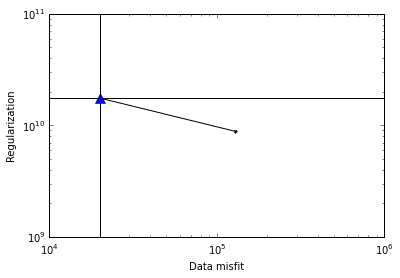

In [43]:
smooth.plot_lcurve()

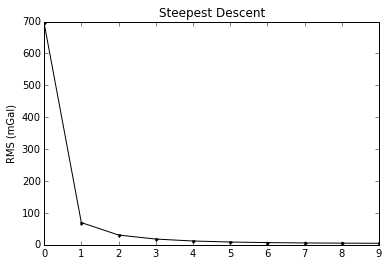

In [47]:
plt.figure()
ax1 = plt.subplot(111)
rms = np.sqrt(smooth.objective_.stats_['objective'])/np.sqrt(solver.ndata)
ax1.plot(rms, '.k-')
ax1.set_ylabel('RMS (mGal)')
ax1.set_title(smooth.objective_.stats_['method'])

In [50]:
predicted = smooth.objective_[0].predicted()
residuals = smooth.objective_[0].residuals()
moho = smooth.estimate_

array([-120., -100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,   40.,
         60.,   80.,  100.,  120.])

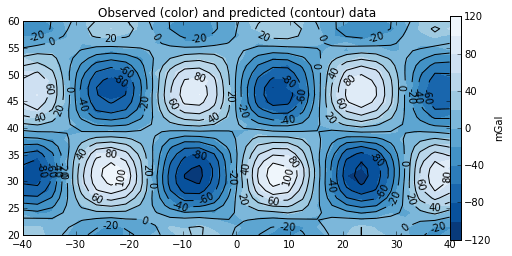

In [51]:
plt.figure(figsize=(9, 4))
plt.title('Observed (color) and predicted (contour) data')
plt.axis('scaled')
levels = mpl.contourf(lon, lat, gz, shape, 12, cmap='Blues_r')
plt.colorbar(pad=0).set_label('mGal')
mpl.contour(lon, lat, predicted, shape, levels)

Mean: 0.290199049665   std: 4.71115414363


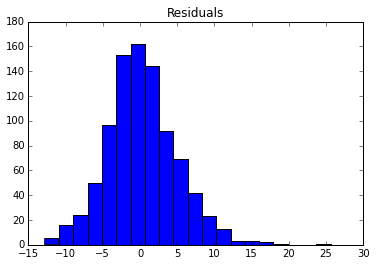

In [52]:
plt.title('Residuals')
plt.hist(residuals, bins=20)
print('Mean: {}   std: {}'.format(residuals.mean(), residuals.std()))

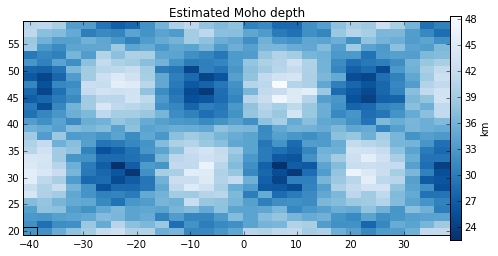

In [53]:
plt.figure(figsize=(9, 4))
plt.title("Estimated Moho depth")
plt.axis('scaled')
mpl.pcolor(lon - dlon/2, lat - dlat/2, -0.001*moho.relief, shape, cmap='Blues_r')
plt.colorbar(pad=0).set_label('km')
mpl.square(model[0].get_bounds()[:4])

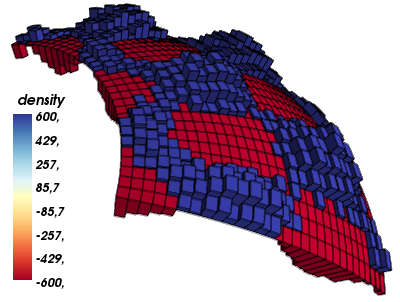

In [41]:
plot_result_3d(moho, 'simple-synthetic-smooth-steepest.png')

**Notice that even when underfitting the data, the solution is still not properly smooth.** 
So it seems that using only the gradient of the smoothness regularization is not enough to fully smooth the solution. The results in Santos et al 2015 are smooth, though. Maybe that's because they start out with a regularized solution from the start.

## Using Gauss-Newton to impose smoothness

Let's see if using Gauss-Newton (and consequently solving the sparse linear systems) improves the smoothness regularization.

In [85]:
regul_params = np.logspace(-8, -3, 10)
regul_params

array([  1.00000000e-08,   3.59381366e-08,   1.29154967e-07,
         4.64158883e-07,   1.66810054e-06,   5.99484250e-06,
         2.15443469e-05,   7.74263683e-05,   2.78255940e-04,
         1.00000000e-03])

In [86]:
smooth2 = LCurve(misfit, regul, regul_params, jobs=ncpu, loglog=False)
smooth2.config('newton', initial=initial, tol=0.2, maxit=10)
t0 = time.time()
smooth2.fit()
dt = time.time() - t0
print("Time it took: {} s".format(dt))

Time it took: 52.3506360054 s


0.000278255940221


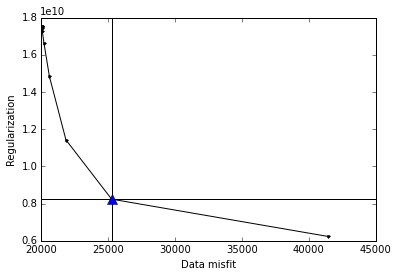

In [87]:
print(smooth2.regul_param_)
smooth2.plot_lcurve()

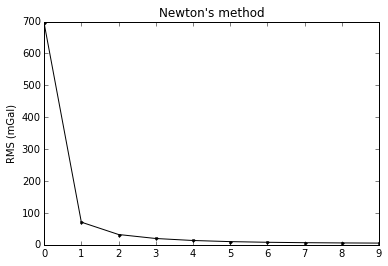

In [88]:
plt.figure()
ax1 = plt.subplot(111)
rms = np.sqrt(smooth2.objective_.stats_['objective'])/np.sqrt(solver.ndata)
ax1.plot(rms, '.k-')
ax1.set_ylabel('RMS (mGal)')
ax1.set_title(smooth2.objective_.stats_['method'])

In [89]:
predicted = smooth2.objective_[0].predicted()
residuals = smooth2.objective_[0].residuals()
moho = smooth2.estimate_

Mean: 0.256747696817   std: 5.29326367649


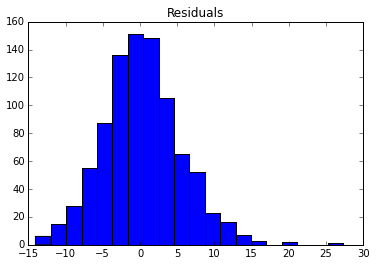

In [90]:
plt.title('Residuals')
plt.hist(residuals, bins=20)
print('Mean: {}   std: {}'.format(residuals.mean(), residuals.std()))

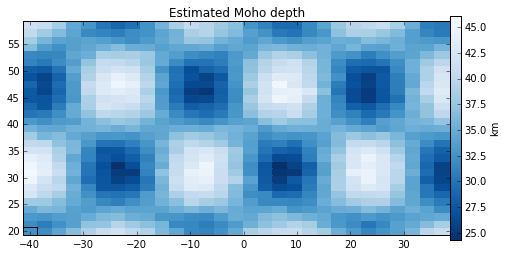

In [91]:
plt.figure(figsize=(9, 4))
plt.title("Estimated Moho depth")
plt.axis('scaled')
mpl.pcolor(lon - dlon/2, lat - dlat/2, -0.001*moho.relief, shape, cmap='Blues_r')
plt.colorbar(pad=0).set_label('km')
mpl.square(model[0].get_bounds()[:4])

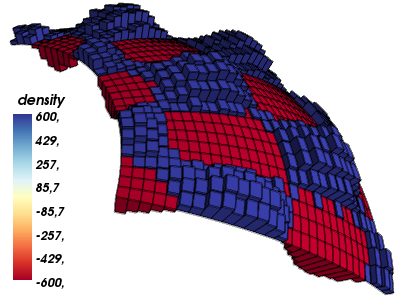

In [92]:
plot_result_3d(moho, 'simple-synthetic-smooth-newton.png')

So using Gauss-Newton optimization we can get proper smoothing of the solution while still fitting the data. 

The computation time is larger because of the extra iterations in Gauss-Newton. If we calculate the time per iteration, for Steepest Descent we have:

In [32]:
7.9/7 # Computation time / n. iterations

1.1285714285714286

and for Gauss-Newton:

In [33]:
14.1/14

1.0071428571428571

So there is no extra cost from using Gauss-Newton and solving the sparse linear system.

## Inverting a Moho with laterally varying density

Lets see if the method for a Moho with a varying density contrast between crust and mantle.

In [48]:
model_varied = model.copy(deep=True)
vardensity = -300*utils.gaussian2d(lon, lat, 50, 30, x0=-20, y0=50, angle=-45) + 600
isabove = model_varied.relief > model_varied.reference
vardensity[isabove] *= -1
model_varied.props['density'] = vardensity

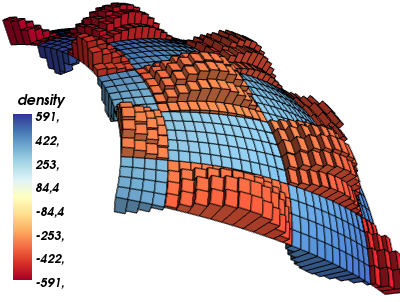

In [49]:
plot_result_3d(model_varied, 'variable-density-synthetic-model.png')

In [50]:
gz = utils.contaminate(tesseroid.gz(lon, lat, h, model_varied, njobs=ncpu), 5, seed=0)

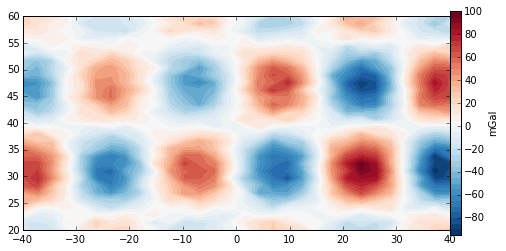

In [51]:
plt.figure(figsize=(9, 4))
plt.axis('scaled')
mpl.contourf(lon, lat, gz, shape, 40, cmap='RdBu_r')
plt.colorbar(pad=0).set_label('mGal')

In [53]:
mesh = model_varied.copy(deep=True)
vardens = MohoGravityInvSpherical(lon, lat, h, gz, mesh, njobs=ncpu) + 5e-4*Smoothness2D(mesh.shape)
vardens.config('newton', initial=initial, tol=0.2, maxit=10) 
t0 = time.time()
vardens.fit()
dt = time.time() - t0
print("Time it took: {} s".format(dt))

Time it took: 9.54055213928 s


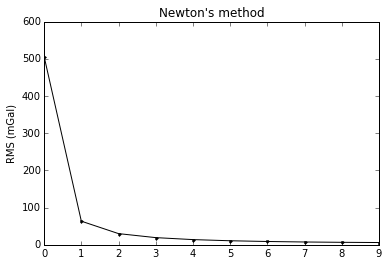

In [54]:
plt.figure()
ax1 = plt.subplot(111)
rms = np.sqrt(vardens.stats_['objective'])/np.sqrt(solver.ndata)
ax1.plot(rms, '.k-')
ax1.set_ylabel('RMS (mGal)')
ax1.set_title(vardens.stats_['method'])

In [55]:
predicted = vardens[0].predicted()
residuals = vardens[0].residuals()
moho = vardens.estimate_

Mean: 0.179267888665   std: 5.93880293321


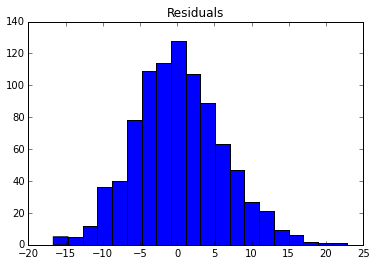

In [56]:
plt.title('Residuals')
plt.hist(residuals, bins=20)
print('Mean: {}   std: {}'.format(residuals.mean(), residuals.std()))

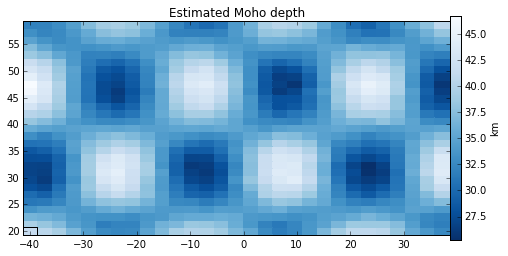

In [57]:
plt.figure(figsize=(9, 4))
plt.title("Estimated Moho depth")
plt.axis('scaled')
mpl.pcolor(lon - dlon/2, lat - dlat/2, -0.001*moho.relief, shape, cmap='Blues_r')
plt.colorbar(pad=0).set_label('km')
mpl.square(model[0].get_bounds()[:4])

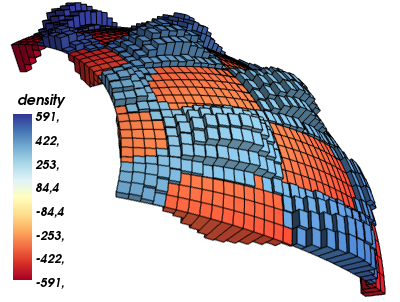

In [59]:
plot_result_3d(moho, 'variable-density-synthetic-result.png')